<H1 style="text-align: center">ECMM422 - Machine Learning</H1>
<H2 style="text-align: center">Assignment 4: Reinforcement Learning</H2>

| Date set     | Hand-in date |
|:------------------|:-----------------------------------|
| 6th March 2020  | **  Wednesday 18th March ** |


This workshop is worth 25% of the total module mark.





Your report should consist of your IPython notebook showing what you did, what was the
result, and what you can conclude from the exercise. Each report will be
assessed on the following criteria:

* Does it record what was done in the exercise?
* Does it permit the results to be reproduced?
* How does the work relate to the theoretical foundations discussed in lectures?
* Is it well presented?

### Submitting the notebooks

Note that an electronic submission is required.  You should also submit the notebook electronically at [electronic hand-in system]( http://empslocal.ex.ac.uk/submit/).  You just need to submit the single .ipynb file that is the notebook, so you should be able to upload it directly from the directory where you have saved it on a University machine or your laptop.  If you're not sure where in your homespace it is, type <code>pwd</code> (print working directory) in a cell to find out where the notebooks are.

<b>Note: you must also submit your cover sheet and E-Submit receipt via BART to complete the submission.</b>


<div class="alert alert-info">
Although you will undoubtedly work collaboratively in the workshops themselves, these are *individual* exercises.  The reports you write should be about the results *you* obtained, and your attention is drawn to the College and University guidelines on collaboration and plagiarism. 
</div>


In [1]:
# including libraries as usual
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors


# Gridworld example

The following code will provide you with a working gridworld problem. You are asked to study the code and use it to provide a solution in the following questions. 


In [127]:
from matplotlib.colors import ListedColormap

class GridWorld: 
    '''
    Class implementing a typical GridWorld problem. 
    
    '''
    
    
    def __init__(self, width, height, gamma=1, penalty=-1, start=[0,0], goal=[0,0], cliff=[], cliff_penalty=-10):
        '''
        Generates a new Gridworld problem, with a grid of size (width,height). 
        gamma: reward discoount parameter (default:1)
        penalty: penalty for each move (default:-1)
        start: start location (default: [0,0])
        goal: goal location (default: [0,0])
        cliff: list of locations defined as cliff (the agent incurs a large penalty for walking into cliffs and is transported back to the start). 
        cliff_penalty: penalty incurred for walking into a cliff (default: -100). 
        '''
        # define the four possible actions
        self.gamma = gamma
        self.actions = range(4)
        self.delta = np.array([[0,-1],[+1,0],[0,+1],[-1,0]])
        self.actions_labels = ['up','right','down','left']
        
        self.states = range(width*height)

        self.width = width
        self.height = height
        
        # set the start state
        self.start = self.encode_state(start)     

        self.cliff = [self.encode_state(s) for s in cliff]
        if np.array(goal).reshape(2,-1).shape[1] == 1:
            self.goal = self.encode_state(goal)
        else:
            self.goal = [self.encode_state(g) for g in goal]
        self.penalty = penalty
        self.cliff_penalty = cliff_penalty
        self.grid = np.zeros((height,width))
        if np.array(goal).reshape(2,-1).shape[1] == 1:
            for c in range(width): 
                for r in range(height): 
                    if [c,r] == goal: 
                        self.grid[r,c] = 1
                    elif [c,r] in cliff: 
                        self.grid[r,c] = 2
                    elif [c,r] == start: 
                        self.grid[r,c] = 3
        else:
            for c in range(width): 
                for r in range(height): 
                    if [c,r] in goal: 
                        self.grid[r,c] = 1
                    elif [c,r] in cliff: 
                        self.grid[r,c] = 2
                    elif [c,r] == start: 
                        self.grid[r,c] = 3
        
    def line_string(self):
        s = '+'
        for j in range(self.width):
            s += '-+'
        s += '\n'
        return s
        
    def tostring(self): 
        '''
            Converts the grid world to a formatted string. 
        '''
        s = 'Grid world:\n'
        for r in range(self.height): 
            s += self.line_string()
            s += '|'
            for c in range(self.width):                 
                if self.grid[r,c] == 1: 
                    s += 'G'
                elif self.grid[r,c] == 2: 
                    s += 'X'
                elif self.grid[r,c] == 3:
                    s += 'S'
                else: 
                    s += ' '
                s += '|'
            s += '\n'
            
        s += self.line_string()
        return s    
    
    def plot_solution(self, S):
        '''
        Display grid as a plot
        '''
        plt.figure()
        plt.xticks(np.arange(0, self.width, 1))
        plt.yticks(np.arange(0, self.height, 1))
        cmap = ListedColormap(['lavender','red','black','forestgreen'])
        
        grid = [[self.grid[x,y] for x in range(self.width)] for y in range(self.height)]
        
        #bounds=[-0.5, 0.5, 1.5, 2.5, 3.5]
        #norm = colors.BoundaryNorm(bounds, cmap.N)
        heatmap = plt.pcolor(np.flip(np.array(self.grid),0), cmap=cmap)
        plt.colorbar(heatmap, ticks=[0, 1, 2, 3])
        plt.grid()
    
    
    def print_solution(self,S): 
        '''
        Graphical display of a solution S, given as a list of states that brings from the initial state to the goal. 
        '''
        s = 'Solution:\n'
        for r in range(self.height): 
            s += self.line_string()
            s += '|'
            for c in range(self.width):                 
                p = self.encode_state((c,r))                
                
                if self.grid[r,c] == 1: 
                    s += 'G'
                elif self.grid[r,c] == 3:
                    s += 'S'
                elif p in S:
                    if p == S[-1]:
                        s += '@'
                    else:
                        s += '*'
                elif self.grid[r,c] == 2: 
                    s += 'X'
                else: 
                    s += ' '
                s += '|'
            s += '\n'
            
        s += self.line_string()
        return s 
    
    
    def plot_grid(self):
        '''
        Display grid as a plot
        '''
        plt.figure(figsize=(self.width, self.height))
        plt.xticks(np.arange(0, self.width, 1))
        plt.yticks(np.arange(0, self.height, 1))
        cmap = ListedColormap(['lavender','red','dimgray','forestgreen'])
        #bounds=[-0.5, 0.5, 1.5, 2.5, 3.5]
        #norm = colors.BoundaryNorm(bounds, cmap.N)
        heatmap = plt.pcolor(np.flip(np.array(self.grid),0), cmap=cmap)
        #plt.colorbar(heatmap, ticks=[0, 1, 2, 3])
        plt.grid()
        
    def plot_states(self):
        '''
        Display grid as a plot with text showing state above
        '''
        plt.figure(figsize=(self.width, self.height))
        plt.xticks(np.arange(0, self.width, 1))
        plt.yticks(np.arange(0, self.height, 1))
        plt.title("States of Gridworld")
        cmap = ListedColormap(['lavender','red','dimgray','forestgreen'])
        #bounds=[-0.5, 0.5, 1.5, 2.5, 3.5]
        #norm = colors.BoundaryNorm(bounds, cmap.N)
        heatmap = plt.pcolor(np.flip(np.array(self.grid),0), cmap=cmap)
        #plt.colorbar(heatmap, ticks=["", "Goal", "Cliff", "Start"])
        plt.grid()
        
        state = np.array(self.states).reshape(self.width, self.height)
        
        for i in range(self.width):
            for j in range(self.height):
                text = plt.text(i + 0.5, self.height - (j + 0.5), state[i,j],
                       ha="center", va="center", color="k")
        
    def plot_value_function(self, V = None, title = ""):
        '''
        Display grid as a plot with value function shown above
        '''
        try:
            if V:
                return False
        except:
            if not len(V) == len(self.states):
                return False
        
        plt.figure(figsize=(self.width, self.height + 0.1))
        plt.xticks(np.arange(0, self.width, 1))
        plt.yticks(np.arange(0, self.height, 1))
        plt.title(title)
        cmap = ListedColormap(['lavender','red','dimgrey','forestgreen'])
        #bounds=[-0.5, 0.5, 1.5, 2.5, 3.5]
        #norm = colors.BoundaryNorm(bounds, cmap.N)
        heatmap = plt.pcolor(np.flip(np.array(self.grid),0), cmap=cmap)
        #plt.colorbar(heatmap, ticks=[0, 1, 2, 3])
        plt.grid()
        
        V = np.round(np.array(V).reshape(self.width,self.height),decimals=2)
        
        for i in range(self.width):
            for j in range(self.height):
                text = plt.text(i + 0.5, self.height - (j + 0.5), round(V[i,j],2), ha="center", va="center", color="k")
        
    
    def show_states(self):
        '''
        Displays state IDs on a grid. 
        '''
        print( np.array(self.states).reshape((self.width,self.height)).T )
    
    def encode_state(self,coord):
        '''
        Converts a tuple (c,r) containing grid coordinates to the corresponding (scalar) state ID. 
        '''
        (c,r) = coord
        if r<self.height and c<self.width and r>=0 and c>=0: 
            return int(c*self.height+r)
        else: 
            return -1
    
    def decode_state(self,s): 
        '''
        Converts a state ID into grid coordinates. 
        '''
        return (s//self.height,s%self.height)
        
    def state_action_state(self,s,a): 
        '''
        Generates the next state and associated reward for a state/action pair. 
        '''
        
        ns = self.encode_state(self.decode_state(s) + self.delta[a,:])
        
        if ns in self.cliff: 
            return [(self.start, self.cliff_penalty)]
        
        # if an invalid state is generated, stay where we are
        elif ns < 0: 
            return [(s,self.penalty)]
        
        # if the goal is reached, no penalty incurred. 
        elif ns == self.goal: 
            return [(ns,0)]
        
        else: 
            return [(ns,self.penalty)]
        
    def state_transition(self,s): 
        '''
        Generates lists of all possible action/next state/reward triplets for the current state. 
        Returns a triplet of lists (sv,pv,rv), with one element per action, where: 
        sv[a] is the next state following the action a.
        pv[a] is the likelihood to select action a (policy). 
        rv[a] is the immediate reward of selecting action a. 
        '''
        
        sv = np.zeros(len(self.actions),dtype='uint')
        pv = np.zeros(len(self.actions))
        rv = np.zeros(len(self.actions))
        
        for a in self.actions: 
            (s2,r2) = self.state_action_state(s,a)[0]
            sv[a] = s2
            pv[a] = 1.0/len(self.actions)
            rv[a] = r2
            
        return (sv,rv,pv)
            
world = GridWorld(6,4, gamma=0.9, goal=[5,3], start=[0,3], cliff=[[1,3],[2,3],[3,3],[4,3]])
print( world.tostring() )

print('GridWorld state indexing:')
print(world.grid)

Grid world:
+-+-+-+-+-+-+
| | | | | | |
+-+-+-+-+-+-+
| | | | | | |
+-+-+-+-+-+-+
| | | | | | |
+-+-+-+-+-+-+
|S|X|X|X|X|G|
+-+-+-+-+-+-+

GridWorld state indexing:
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [3. 2. 2. 2. 2. 1.]]


## 1. Policy evaluation

One simple way to solve a reinforcement learning problem is to estimate the value function for the whole problem and then apply a greedy strategy to find the goal. In the first part you are asked to evaluate the value function V(s) for all states (ie, grid cells), using <b>policy iteration</b>, as discussed in class. 
Iterative policy evaluation proposes an update of the value function based on the recursive formulation of the <i>Bellman equation</i>: 

$$
V^{(t+1)}(S_t) \leftarrow \sum_{S_{t+1},R_{t+1}} p\left[S_{t+1},R_{t+1}|S_t,\pi(S_t)\right] \left(R_{t+1}+\gamma V^{t}(S_{t+1})\right)
$$

In this part, you will:

a. Estimate the value of V(s) using policy iteration. Each step of policy iteration will take as parameter the problem to be solved (which will provide the required functions) and the current estimate of the value function (as an array with length equal to the grid size). 
<div style="text-align: right"><b>[10 marks]</b></div>

b. Print out the estimated value function after 1,2,5 and 10 iterations. 
<div style="text-align: right"><b>[10 marks]</b></div>

c. Provide a solution using a greedy strategy and the estimated value function. Print it out using the print_solution() method. 
<div style="text-align: right"><b>[10 marks]</b></div>

[[ 0  5 10 15 20]
 [ 1  6 11 16 21]
 [ 2  7 12 17 22]
 [ 3  8 13 18 23]
 [ 4  9 14 19 24]]


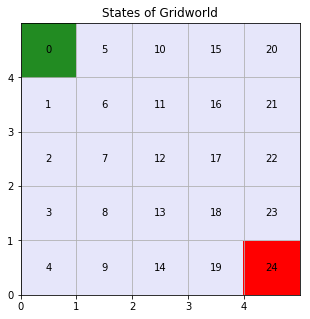

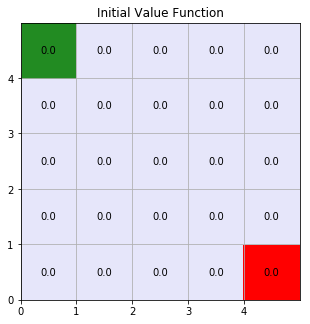

In [108]:
world = GridWorld(5,5, gamma=0.9, start=[0,0], goal=[4,4])
np.set_printoptions(precision=2)

world.show_states()
#world.plot_grid()
world.plot_states()

V = np.zeros(len(world.states))
#print(V.reshape((world.width,world.height)).T)
world.plot_value_function(V = V, title = "Initial Value Function")

### 1.a/b:
For this part I am required to define the functions to find the value of V(S) from the policy iteration function from the Bellman's equation. In the course literature, the psuedo code for this as an iterative formula is given. After this an example is covered where it goes through the calculation of a policy. For testing, this is the grid that will be used.

*Note: Edits made to GridWorld function made to allow for multiple goals*

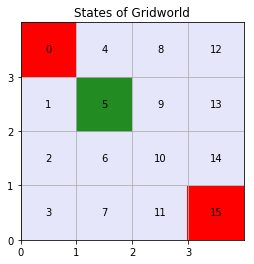

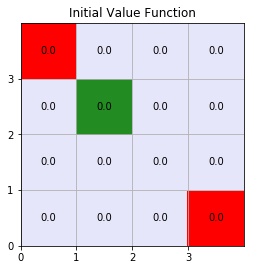

In [139]:
test_world = GridWorld(4,4, gamma=1.0, start=[1,1], goal=[[3,3],[0,0]])
np.set_printoptions(precision=2)

#world.show_states()
#world.plot_grid()
test_world.plot_states()

V = np.zeros(len(test_world.states))
#print(V.reshape((world.width,world.height)).T)
test_world.plot_value_function(V = V, title = "Initial Value Function")

The psuedo-code for the iterative policy evaluation is as follows:

\begin{align*}
\textbf{Input: } \pi& \text{,  policy to be evaluated.} \\ \\
\text{Initialize}&  \text{ an array} V(S) = 0,\forall{s} \in S   \\
\textbf{repeat:}& \\
&\Delta  \leftarrow 0 \\
&\textbf{for } s \in S \textbf{ do} \\
&\qquad v \leftarrow V(s) \\
&\qquad V(s) \leftarrow \sum_{s', r} p[s', r\mid s, \pi(s)](r + \gamma V(s')) \\
&\qquad \Delta \leftarrow max(\delta, \mid v - V(s) \mid) \\
\textbf{until: }& \Delta < \epsilon \\
\textbf{return }& V
\end{align*}

This is defined for this project below.

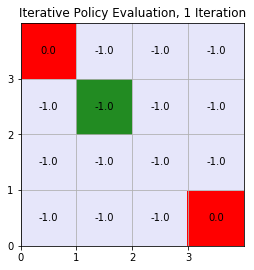

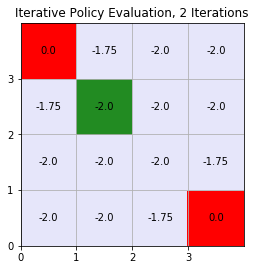

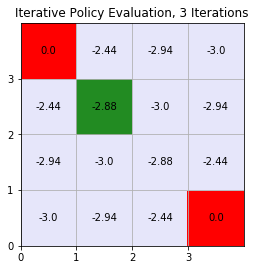

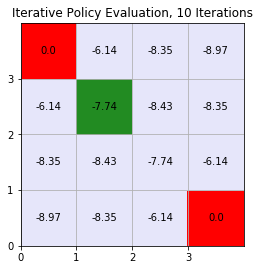

In [142]:
def iterative_policy_evaluation(world, ite = 1):
    V = np.zeros(len(world.states))
    g = np.array(world.grid).flatten()
    states = [s for s in world.states if (not g[s] == 1.0)]
    for i in range(ite):
        delta = 0
        Vdash = np.zeros(len(world.states))
        for s in states:
            v = V[s]
            #print(f"State: {s}, \n\t transitions: {world.state_transition(s)}")
            sv, rv, pv = world.state_transition(s)
            nV = 0
            for dash in range(len(sv)):
                nV += pv[dash] * (rv[dash] + (world.gamma * V[sv[dash]]))
            Vdash[s] = nV
        V = Vdash
    return V

'''
Using "test" world from the literature
'''

V = iterative_policy_evaluation(test_world)
test_world.plot_value_function(V = V, title = "Iterative Policy Evaluation, 1 Iteration")

V = iterative_policy_evaluation(test_world, ite = 2)
test_world.plot_value_function(V = V, title = "Iterative Policy Evaluation, 2 Iterations")

V = iterative_policy_evaluation(test_world, ite = 3)
test_world.plot_value_function(V = V, title = "Iterative Policy Evaluation, 3 Iterations")

V = iterative_policy_evaluation(test_world, ite = 10)
test_world.plot_value_function(V = V, title = "Iterative Policy Evaluation, 10 Iterations")

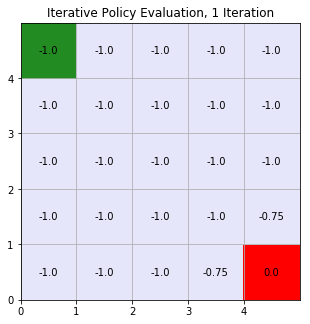

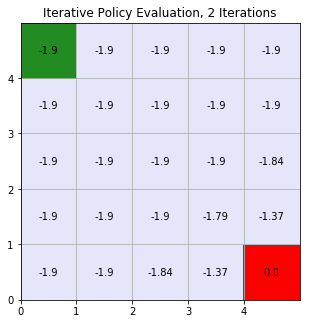

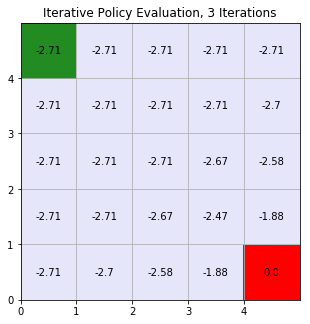

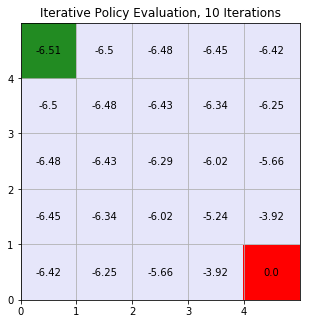

In [141]:
world = GridWorld(5,5, gamma=0.9, start=[0,0], goal=[4,4])

V = iterative_policy_evaluation(t_world)
world.plot_value_function(V = V, title = "Iterative Policy Evaluation, 1 Iteration")

V = iterative_policy_evaluation(t_world, ite = 2)
world.plot_value_function(V = V, title = "Iterative Policy Evaluation, 2 Iterations")

V = iterative_policy_evaluation(t_world, ite = 3)
world.plot_value_function(V = V, title = "Iterative Policy Evaluation, 3 Iterations")

V = iterative_policy_evaluation(t_world, ite = 10)
world.plot_value_function(V = V, title = "Iterative Policy Evaluation, 10 Iterations")

## 2. State-Action-Reward-State-Action (SARSA)
Value iteration requires a complete knowledge of the problem and its dynamics (ie, the capacity to simulate any state). In any practical problem this is not the case. Consider a robot operating: It is limited to learning from the actual experiences it encounters, and can only speculate on what could have been. 

SARSA is a reinforcement algorithms that reformulates the Temporal Difference (TD) rule seen before to allow the learning of a value function for state-action pairs (ie, the value of an action in a given state) from limited experiences only.  
In SARSA, the state-action value function $Q^{(t)}(S_t,A_t)$ is learnt by updating: 
$$
		Q^{(t+1)}(S_t, A_t) \leftarrow Q^{(t)}(S_t,A_t) + \alpha \left[R_{t+1} + \gamma Q^{(t)}(S_{t+1},A_{t+1}) - Q^{(t)}(S_t,A_t)\right]   
$$

In this part, you will:

a. Implement the SARSA algorithm, using an $\epsilon$-greedy policy. 
<div style="text-align: right"><b>[10 marks]</b></div>
b. Produce a graph showing the performance of the agent in y-axis and the number of episodes in x-axis. 
<div style="text-align: right"><b>[10 marks]</b></div>
b. C Finally, show the solution your algorithm has reached for different values of $\epsilon$.
<div style="text-align: right"><b>[10 marks]</b></div>


## 3. Q-learning 
SARSA is called an "on-policy" algorithm, because it makes assumptions on what the action that the policy will make at the next step to estimate $Q$. Therefore, the value function is dependent on the policy! 
$Q$-learning takes an alternative view, so-called "off-policy", where the value of a state-action pair is independent on the policy's actions, and is instead dependent on <i>the best possible course of action thereafter</i>. This is achieved by amending the update function: 
    $$
	Q^{(t+1)}(S_t,A_t)\leftarrow Q^{(t)}(S_t,A_t)+\alpha\left[
	R_{t+1} + \gamma \max_a Q^{(t)}(S_{t+1},a)-Q(S_t,A_t)
	\right]
	$$
    
In this part, you will:

a. implement the off-policy Q-learning algorithm and use it to solve the problem. 
<div style="text-align: right"><b>[10 marks]</b></div>
b. Produce a graph showing the performance of the agent in y-axis and the number of episodes in x-axis. 
<div style="text-align: right"><b>[10 marks]</b></div>
c. C Finally, show the solution your algorithm has reached for different values of $\epsilon$.
<div style="text-align: right"><b>[10 marks]</b></div>

Finally, compare the two algorithms on a number of gridworld configurations (see examples below, but generate a few of your own) and discuss the results. 
<div style="text-align: right"><b>[10 marks]</b></div>

In [ ]:
world1 = GridWorld(10,10, gamma=0.9, start=[0,0], goal=[9,9], cliff=[[0,2], [1,2], [2,2], [3,2], [4,2], [5,2], 
                                                                     [4,6], [5,6], [6,6], [7,6], [8,6], [9,6]])
print(world1.tostring())

cliff = [ [i,j] for i in range(3,7) for j in range(3,7) ]
       
world2 = GridWorld(10,10, gamma=0.9, start=[9,0], goal=[0,9], cliff=cliff)
print(world2.tostring())


